In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.plots import *

from matplotlib import patches, patheffects

from pathlib import Path

cuda.set_device(0)

C:\Users\chrun\Anaconda3\envs\fastai\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Stage 1 Dataset

In [3]:
PATH = Path('data')
TMP_PATH = "tmp/tmp"
MODEL_PATH = "tmp/model/"
sz = 128
arch = resnet34
bs = 128

In [4]:
train_bb_fn = f'{PATH}/stage_1_train_labels.csv'

In [5]:
# Rewrite the train csv file to contain only two columns as expected by fastai'
train_bb_df = pd.read_csv(train_bb_fn)
train_bb_df.head()

,patientId,bbox
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0 0 0 0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,0 0 0 0
2,00322d4d-1c29-4943-afc9-b6754be640eb,0 0 0 0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0 0 0 0
4,00436515-870c-4b36-a041-de91049b9ab4,152 264 530 476


In [6]:
train_bb_fn = PATH/'bbs.csv'
train_label_fn = PATH/'train_target_labels.csv'

In [7]:
train_bb_fn.open().readlines()[:6]

['patientId,bbox\n',
 '0004cfab-14fd-4e49-80ba-63a80b6bddd6,\n',
 '00313ee0-9eaa-42f4-b0ab-c148ed3241cd,\n',
 '00322d4d-1c29-4943-afc9-b6754be640eb,\n',
 '003d8fa0-6bf1-40ed-b54c-ac657f8495c5,\n',
 '00436515-870c-4b36-a041-de91049b9ab4,152 264 530 476\n']

In [8]:
train_label_fn.open().readlines()[:6]

['patientId,Target\n',
 '0004cfab-14fd-4e49-80ba-63a80b6bddd6,0\n',
 '00313ee0-9eaa-42f4-b0ab-c148ed3241cd,0\n',
 '00322d4d-1c29-4943-afc9-b6754be640eb,0\n',
 '003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0\n',
 '00436515-870c-4b36-a041-de91049b9ab4,1\n']

In [9]:
#train_bb_df = pd.read_csv(train_bb_fn)
#train_bb_df['bbox'] = train_bb_df['bbox'].apply(lambda x: '' if x == '    ' else x)

#train_bb_df['bbox'].fillna('    ', inplace=True)
#train_bb_df.to_csv(train_bb_fn, index=False)

In [10]:
#if you want no randomness:
#np.random.seed(args.manualSeed)
#torch.manual_seed(args.manualSeed)
#torch.cuda.manual_seed_all(args.manualSeed)

In [11]:
n = len(train_bb_fn.open().readlines())-1
val_idxs = get_cv_idxs(n) # random 20% data for validation set

In [12]:
def convert_bbox(bbox): 
    """
    convert bounding box from x, y, height width,
    to x1, y1 (top left) & x2, y2 (bottom right)
    """
    return np.array([bbox[1], 
                     bbox[0], 
                     bbox[3] + bbox[1] - 1, 
                     bbox[2] + bbox[0] - 1]) 

def revert_bbox(bbox):
    """
    revert bounding box back to original dimensions
    """
    return np.array([bbox[1], 
                 bbox[0], 
                 bbox[3] - bbox[1] + 1, 
                 bbox[2] - bbox[0] + 1])

In [13]:
tfm_y = TfmType.COORD

aug_tfms = [RandomFlip(tfm_y=tfm_y),
            RandomRotate(3, p=0.5, tfm_y=tfm_y),
            RandomLighting(0.05, 0.05, tfm_y=tfm_y)]

In [14]:
def get_data(sz):
    tfms = tfms_from_model(arch, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=aug_tfms)
    
    data = ImageClassifierData.from_csv(PATH, 
                                        'stage_1_train_images', 
                                        train_bb_fn, 
                                        tfms=tfms, 
                                        test_name='stage_1_test_images',
                                        continuous=True,
                                        val_idxs=val_idxs,  
                                        suffix='.dcm', 
                                        bs=bs)

    data2 = ImageClassifierData.from_csv(PATH, 'stage_1_train_images', train_label_fn, tfms=tfms_from_model(arch, sz))
    return data, data2

In [15]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

In [16]:
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

In [17]:
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)

In [18]:
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='blue', fontsize=sz, weight='bold')
    draw_outline(text, 1)

In [ ]:
data, data2 = get_data(128)

In [ ]:
class ConcatLblDataset(Dataset):
    def __init__(self, ds, y2): self.ds,self.y2 = ds,y2
    def __len__(self): return len(self.ds)
    
    def __getitem__(self, i):
        x,y = self.ds[i]
        return (x, (y,self.y2[i]))

In [ ]:
trn_ds2 = ConcatLblDataset(data.trn_ds, data2.trn_y)
val_ds2 = ConcatLblDataset(data.val_ds, data2.val_y)

In [ ]:
val_ds2[2][1]

In [ ]:
data.trn_dl.dataset = trn_ds2
data.val_dl.dataset = val_ds2

In [ ]:
x,y=next(iter(data.val_dl))
idx=2
ima=data.val_ds.ds.denorm(to_np(x))[idx]
b = revert_bbox(to_np(y[0][idx])); b

In [ ]:
ax = show_img(ima)
draw_rect(ax, b)
draw_text(ax, b[:2], data2.classes[y[1][idx]])

In [ ]:
asdf = pydicom.read_file('data/stage_1_train_images/0a03a65b-9e45-4e3d-ae6c-b8a37112ab31.dcm')

In [ ]:
asdf #TODO: work the categories like birth date, sex etc into the nn

In [ ]:
head_reg4 = nn.Sequential(
    Flatten(),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(8192,256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    nn.Linear(256,4+2),
)
models = ConvnetBuilder(arch, 0, 0, 0, custom_head=head_reg4)

learn = ConvLearner(data, models)
learn.opt_fn = optim.Adam

In [ ]:
def detn_loss(input, target):
    bb_t,c_t = target
    bb_i,c_i = input[:, :4], input[:, 4:]
    bb_i = F.sigmoid(bb_i)*128
    # I looked at these quantities separately first then picked a multiplier
    #   to make them approximately equal
    #print('l1loss: ' + str(F.l1_loss(bb_i, bb_t)))
    #print('cross_entropy: ' + str(F.cross_entropy(c_i, c_t)))
    return F.l1_loss(bb_i, bb_t) + F.cross_entropy(c_i, c_t)*70

def detn_l1(input, target):
    bb_t,_ = target
    bb_i = input[:, :4]
    bb_i = F.sigmoid(bb_i)*128
    return F.l1_loss(V(bb_i),V(bb_t)).data

def detn_acc(input, target):
    _,c_t = target
    c_i = input[:, 4:]
    return accuracy(c_i, c_t)

learn.crit = detn_loss
learn.metrics = [detn_acc, detn_l1]

In [ ]:
learn

In [ ]:
learn.lr_find()

In [ ]:
learn.sched.plot()

In [ ]:
lr = 2e-2

# Fitting
## first image size 128

In [ ]:
learn.fit(lr, 1, cycle_len = 3, cycle_mult = 1)

In [ ]:
learn.save('astronomical_classification_128_3E')

In [ ]:
#learn.load('astronomical_classification_128_3E')

In [ ]:
lrs = np.array([lr/9,lr/3,lr])
learn.unfreeze()

In [ ]:
learn.fit(lrs, 3, cycle_len = 1, cycle_mult = 2, best_save_name='astronomical_classification_128_3E7ER')

In [ ]:
learn.save('astronomical_classification_128_3E7ER2')

In [ ]:
#learn.load('astronomical_classification_64_3E7ER')

In [ ]:
plt.figure(1,figsize=(18, 8))
plt.subplot(121)
plt.plot(learn.sched.lrs)
plt.subplot(122)
plt.plot(learn.sched.losses)
plt.show()

In [ ]:
y = learn.predict()
x,_ = next(iter(data.val_dl))

In [ ]:
from scipy.special import expit

In [ ]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=data.val_ds.ds.denorm(to_np(x))[i]
    bb = expit(y[i][:4])*128
    b = revert_bbox(bb)
    c = np.argmax(y[i][4:])
    ax = show_img(ima, ax=ax)
    draw_rect(ax, b)
    draw_text(ax, b[:2], data2.classes[c])
plt.tight_layout()

## image size 256

In [19]:
data, data2 = get_data(256)

In [20]:
class ConcatLblDataset(Dataset):
    def __init__(self, ds, y2): self.ds,self.y2 = ds,y2
    def __len__(self): return len(self.ds)
    
    def __getitem__(self, i):
        x,y = self.ds[i]
        return (x, (y,self.y2[i]))

In [21]:
trn_ds2 = ConcatLblDataset(data.trn_ds, data2.trn_y)
val_ds2 = ConcatLblDataset(data.val_ds, data2.val_y)

In [22]:
val_ds2[2][1]

(array([128., 163., 197., 212.], dtype=float32), 1)

In [23]:
data.trn_dl.dataset = trn_ds2
data.val_dl.dataset = val_ds2

In [24]:
head_reg4 = nn.Sequential(
    Flatten(),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(32768,256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    nn.Linear(256,4+2),
)
models = ConvnetBuilder(arch, 0, 0, 0, custom_head=head_reg4)

learn = ConvLearner(data, models)
learn.opt_fn = optim.Adam

In [25]:
def detn_loss(input, target):
    bb_t,c_t = target
    bb_i,c_i = input[:, :4], input[:, 4:]
    bb_i = F.sigmoid(bb_i)*256
    # I looked at these quantities separately first then picked a multiplier
    #   to make them approximately equal
    #print('l1loss: ' + str(F.l1_loss(bb_i, bb_t)))
    #print('cross_entropy: ' + str(F.cross_entropy(c_i, c_t)))
    return F.l1_loss(bb_i, bb_t) + F.cross_entropy(c_i, c_t)*150

def detn_l1(input, target):
    bb_t,_ = target
    bb_i = input[:, :4]
    bb_i = F.sigmoid(bb_i)*256
    return F.l1_loss(V(bb_i),V(bb_t)).data

def detn_acc(input, target):
    _,c_t = target
    c_i = input[:, 4:]
    return accuracy(c_i, c_t)

learn.crit = detn_loss
learn.metrics = [detn_acc, detn_l1]

In [ ]:
learn.lr_find()

In [ ]:
learn.sched.plot()

In [26]:
lr = 8e-2

In [ ]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=1)

In [ ]:
learn.save('astronomical_classification_256_3E')

In [27]:
learn.load('astronomical_classification_256_3E')

In [29]:
lrs = np.array([lr/9,lr/3,lr])

In [30]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len = 1, cycle_mult = 2, best_save_name='astronomical_classification_256_3E7ER')

epoch      trn_loss   val_loss   detn_acc   detn_l1                                                                    
    0      104.069339 98.332602  0.791789   32.246515 
    1      108.884318 110.677377 0.767638   35.079003                                                                  
    2      97.951062  95.35736   0.803347   32.280573                                                                  
    3      111.773736 45186.070668 0.721063   37.686283                                                                
    4      102.186404 102.479843 0.805762   36.402589                                                                  
    5      95.372216  94.083236  0.812834   33.103517                                                                  
    6      90.982585  89.678291  0.817319   30.28172                                                                   



[89.67829129974328, 0.8173193030466761, 30.281720132977465]

In [32]:
learn.save('astronomical_classification_256_3E7ER2')

## Stage 2 Dataset

In [33]:
y = learn.predict()
x,_ = next(iter(data.val_dl))

In [34]:
from scipy.special import expit

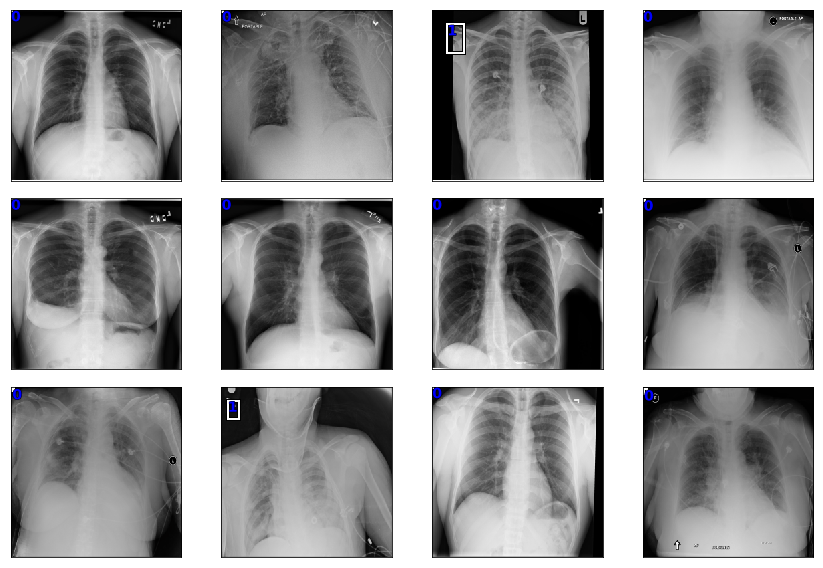

In [35]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=data.val_ds.ds.denorm(to_np(x))[i]
    bb = expit(y[i][:4])*128
    b = revert_bbox(bb)
    c = np.argmax(y[i][4:])
    ax = show_img(ima, ax=ax)
    draw_rect(ax, b)
    draw_text(ax, b[:2], data2.classes[c])
plt.tight_layout()